In [1]:
"""
  @inproceedings{Johnson10,
   title = {Clustered Pose and Nonlinear Appearance Models for Human Pose Estimation},
   author = {Johnson, Sam and Everingham, Mark},
   year = {2010},
   booktitle = {Proceedings of the British Machine Vision Conference},
   note = {doi:10.5244/C.24.12}
}
"""

'\n  @inproceedings{Johnson10,\n   title = {Clustered Pose and Nonlinear Appearance Models for Human Pose Estimation},\n   author = {Johnson, Sam and Everingham, Mark},\n   year = {2010},\n   booktitle = {Proceedings of the British Machine Vision Conference},\n   note = {doi:10.5244/C.24.12}\n}\n'

In [2]:
! wget http://sam.johnson.io/research/lsp_dataset_original.zip

--2022-08-13 22:51:04--  http://sam.johnson.io/research/lsp_dataset_original.zip
Resolving sam.johnson.io (sam.johnson.io)... 40.70.30.232
Connecting to sam.johnson.io (sam.johnson.io)|40.70.30.232|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264200740 (252M) [application/zip]
Saving to: ‘lsp_dataset_original.zip’

lsp_dataset_origina 100%[===================>] 251.96M  40.1MB/s    in 6.8s    

2022-08-13 22:51:11 (37.0 MB/s) - ‘lsp_dataset_original.zip’ saved [264200740/264200740]



In [3]:
import os
import sys
import cv2
import time
import json
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import scipy.io
import cv2
import random
import shutil   # this lib is for cut and paste files


NUMBER_OF_POINTS = 14

In [4]:

os.mkdir("train")

! unzip "lsp_dataset_original.zip" 

shutil.move("images", "train/images")

Archive:  lsp_dataset_original.zip
   creating: images/
  inflating: images/im0001.jpg       
  inflating: images/im0002.jpg       
  inflating: images/im0003.jpg       
  inflating: images/im0004.jpg       
  inflating: images/im0005.jpg       
  inflating: images/im0006.jpg       
  inflating: images/im0007.jpg       
  inflating: images/im0008.jpg       
  inflating: images/im0009.jpg       
  inflating: images/im0010.jpg       
  inflating: images/im0011.jpg       
  inflating: images/im0012.jpg       
  inflating: images/im0013.jpg       
  inflating: images/im0014.jpg       
  inflating: images/im0015.jpg       
  inflating: images/im0016.jpg       
  inflating: images/im0017.jpg       
  inflating: images/im0018.jpg       
  inflating: images/im0019.jpg       
  inflating: images/im0020.jpg       
  inflating: images/im0021.jpg       
  inflating: images/im0022.jpg       
  inflating: images/im0023.jpg       
  inflating: images/im0024.jpg       
  inflating: images/im0025.jpg  

'train/images'

In [5]:

joints = scipy.io.loadmat('joints.mat')
joints = joints['joints']
joints = np.swapaxes(joints,0,2)
joints = np.swapaxes(joints,1,2)

In [6]:
joints[:,:,0]

array([[473.95283019, 552.63152053,   0.        ],
       [132.60309278, 780.94587629,   0.        ],
       [451.1281909 , 455.24805771,   0.        ],
       ...,
       [593.3490566 , 605.91675916,   0.        ],
       [223.94659207, 348.56103764,   0.        ],
       [492.46892342, 825.04162042,   0.        ]])

In [7]:
joints = joints[: , 0:2 , :]

In [8]:
joints.shape  # (2000, 2, 14)

(2000, 2, 14)

In [9]:
joints[:,:,0]

array([[473.95283019, 552.63152053],
       [132.60309278, 780.94587629],
       [451.1281909 , 455.24805771],
       ...,
       [593.3490566 , 605.91675916],
       [223.94659207, 348.56103764],
       [492.46892342, 825.04162042]])

In [10]:
model_ft = models.vgg16(pretrained=True)

# model_ft.classifier = nn.Linear(25088, 512)

model_ft
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
def get_model(model_name, pretrained=True):
    return models.__dict__[model_name](pretrained)

def draw_point_on_image(image , points):
  img = image.copy()
  for i in range(NUMBER_OF_POINTS):
    color=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    img = cv2.circle(img, (int(points[0,i]),int(points[1,i])), radius=1, color=color, thickness=40)
  return img

In [12]:
models.__dict__

{'AlexNet': torchvision.models.alexnet.AlexNet,
 'AlexNet_Weights': <enum 'AlexNet_Weights'>,
 'ConvNeXt': torchvision.models.convnext.ConvNeXt,
 'ConvNeXt_Base_Weights': <enum 'ConvNeXt_Base_Weights'>,
 'ConvNeXt_Large_Weights': <enum 'ConvNeXt_Large_Weights'>,
 'ConvNeXt_Small_Weights': <enum 'ConvNeXt_Small_Weights'>,
 'ConvNeXt_Tiny_Weights': <enum 'ConvNeXt_Tiny_Weights'>,
 'DenseNet': torchvision.models.densenet.DenseNet,
 'DenseNet121_Weights': <enum 'DenseNet121_Weights'>,
 'DenseNet161_Weights': <enum 'DenseNet161_Weights'>,
 'DenseNet169_Weights': <enum 'DenseNet169_Weights'>,
 'DenseNet201_Weights': <enum 'DenseNet201_Weights'>,
 'EfficientNet': torchvision.models.efficientnet.EfficientNet,
 'EfficientNet_B0_Weights': <enum 'EfficientNet_B0_Weights'>,
 'EfficientNet_B1_Weights': <enum 'EfficientNet_B1_Weights'>,
 'EfficientNet_B2_Weights': <enum 'EfficientNet_B2_Weights'>,
 'EfficientNet_B3_Weights': <enum 'EfficientNet_B3_Weights'>,
 'EfficientNet_B4_Weights': <enum 'Effici

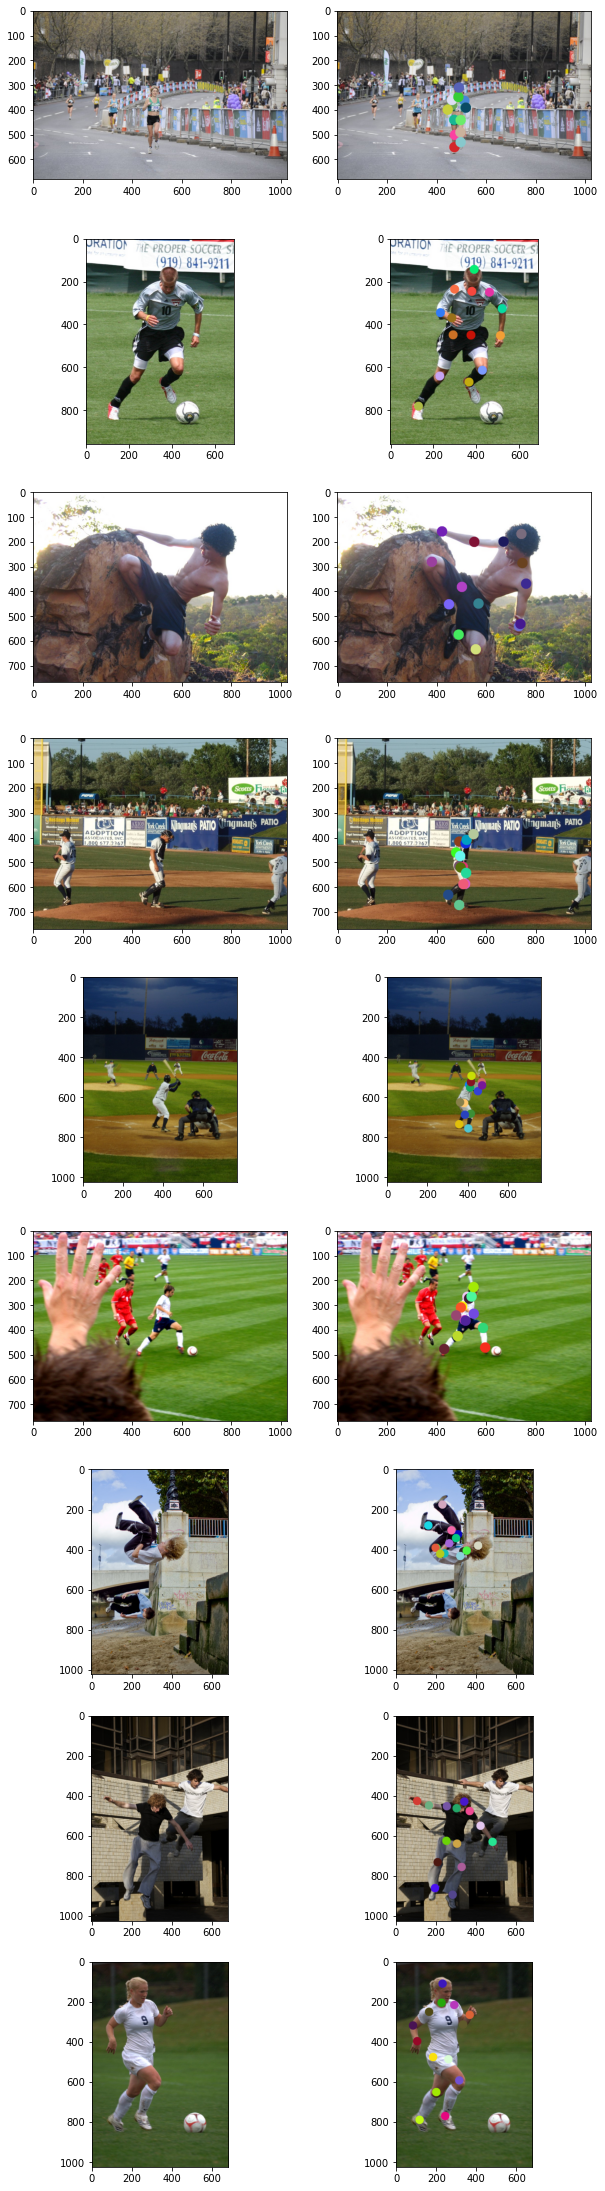

In [13]:

f, axarr = plt.subplots(9,2 , figsize=(10, 40))
for i in range(9):
  image = cv2.imread("train/images/im000"+str(i+1)+".jpg")
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  pointed_img = draw_point_on_image(image , joints[i])
  axarr[i,0].imshow(image)
  axarr[i,1].imshow(pointed_img)
 

## make validation directory

In [14]:



val_percentage = 0.2
os.mkdir("val")
os.mkdir("val/images")

train_joints = joints
val_joints = []

val_list = random.sample(range(1,2001), int(2000 * val_percentage))
val_list.sort()

for i in val_list[::-1]:
  num = str(i).zfill(4)
  shutil.move("train/images/im"+num+".jpg", "val/images/im"+num+".jpg")
  val_joints.append(train_joints[i-1])
  train_joints = np.delete(train_joints, i-1, 0)




In [15]:
val_joints = val_joints[::-1]

In [16]:
aa = np.array([1,2,3,4,45,76,9,3])
aa = np.delete(aa, 6, 0)
aa

array([ 1,  2,  3,  4, 45, 76,  3])

In [17]:
val_list

[3,
 6,
 11,
 12,
 15,
 16,
 26,
 39,
 41,
 52,
 54,
 59,
 60,
 61,
 66,
 68,
 71,
 76,
 82,
 83,
 93,
 101,
 103,
 109,
 113,
 115,
 117,
 120,
 129,
 132,
 134,
 141,
 145,
 150,
 156,
 161,
 164,
 169,
 174,
 177,
 186,
 192,
 194,
 203,
 211,
 220,
 221,
 231,
 237,
 245,
 250,
 257,
 261,
 268,
 271,
 273,
 293,
 301,
 317,
 319,
 323,
 326,
 332,
 339,
 342,
 345,
 346,
 348,
 364,
 366,
 372,
 374,
 375,
 378,
 384,
 393,
 395,
 397,
 401,
 408,
 421,
 423,
 428,
 429,
 430,
 434,
 454,
 455,
 457,
 463,
 469,
 474,
 475,
 483,
 487,
 492,
 501,
 508,
 517,
 521,
 524,
 533,
 547,
 552,
 557,
 559,
 560,
 566,
 569,
 575,
 583,
 595,
 604,
 608,
 610,
 617,
 629,
 630,
 632,
 637,
 645,
 646,
 652,
 661,
 665,
 679,
 680,
 683,
 710,
 722,
 723,
 727,
 729,
 731,
 733,
 741,
 743,
 745,
 754,
 761,
 770,
 774,
 780,
 787,
 793,
 794,
 795,
 798,
 799,
 804,
 805,
 806,
 809,
 812,
 826,
 834,
 844,
 845,
 846,
 848,
 852,
 859,
 862,
 876,
 892,
 895,
 899,
 902,
 904,
 906,
 91

In [18]:

train_dir = 'train'
valid_dir = 'val'
anno_dir = 'joints.mat'

sz = 512  # image size
bs = 16   # batch size
model_name0 = 'resnet34'
model_name1 = 'vgg16'



## Dataset

In [19]:
len(train_joints)

1600

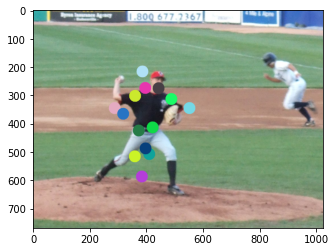

In [20]:
image = cv2.imread("train/images/im0020.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pointed_img = draw_point_on_image(image , train_joints[14])
plt.imshow(pointed_img)

In [21]:
num = str(54).zfill(4)

int(num)

54

In [22]:
class PoseDataset(Dataset):
    def __init__(self, ds, joints, sz=512):
        """ Prepare fish dataset
        
        Inputs:
            root: the directory which contains all required data such as images, labels, etc.
            ds: torchvision ImageFolder dataset.
            joints: a dictionary containing the coordinates of the bounding box in each images
            transforms: required transformations on each image
        """
        self.imgs = ds.imgs
        self.joints = joints
        self.sz = sz
        self.tfms = transforms.Compose([
            transforms.Resize((sz, sz)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def __getitem__(self, index):
        img, _ = self.imgs[index]
        
        joint = self.joints[index].copy()
        
        # print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$    " , joints)
      

        # read image and perform transformations

        image = Image.open(img).convert('RGB')
        w, h = image.size
        
        w_scale = sz / w
        h_scale = sz / h
        
        # transformations
        image = self.tfms(image)
        
        # normalize and scale bounding box
     
        joint[0] = (joint[0] / w) * w_scale
        joint[1] = (joint[1] / h) * h_scale
  
        
        # return image tensor, label tensor and bounding box tensor
        return image, torch.Tensor(joint), (w, h)
    
    def __len__(self):
        return len(self.imgs)

In [23]:
# training data
train_data = datasets.ImageFolder(train_dir)
train_ds = PoseDataset(train_data, train_joints, sz=sz)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

# validation data
valid_data = datasets.ImageFolder(valid_dir)
valid_ds = PoseDataset(valid_data, val_joints, sz=sz)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)

In [24]:
train_features, train_labels , (w ,h) = next(iter(valid_dl))

In [25]:
train_features.shape

torch.Size([16, 3, 512, 512])

## model

In [26]:
class Localizer(nn.Module):
    def __init__(self, model_name0, model_name1):
        super(Localizer, self).__init__()  


        # self.branch1 =nn.Sequential(
        #   nn.Conv2d(3,32,kernel_size=3,padding=1),
        #   nn.ReLU(),
        #   nn.MaxPool2d(2,2),
        #   nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        #   nn.ReLU(),
        #   nn.MaxPool2d(2,2),

        #   nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        #   nn.ReLU(),
        #   nn.MaxPool2d(2,2),
        #   nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        #   nn.ReLU(),
        #   nn.MaxPool2d(2,2),

        #   nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        #   nn.ReLU(),
        #   nn.MaxPool2d(2,2),
        #   nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        #   nn.ReLU(),
        #   nn.MaxPool2d(2,2),

        #   nn.Conv2d(256,128,kernel_size=3,stride=1,padding=1),
        #   nn.ReLU(),
        #   nn.MaxPool2d(2,2),
        #   nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        #   nn.ReLU(),
        #   nn.MaxPool2d(2,2),


        #   nn.Flatten())



        # create cnn model
        model0 = get_model(model_name0)

        model1 = get_model(model_name1)
      
        # remove fc layers and add a new fc layer
        num_features = model0.fc.in_features
        model0.fc = nn.Linear(num_features, 512) #  localizer
        self.model0 = model0

        model1.classifier = nn.Linear(25088, 512)
        self.model1 = model1


        self.fc1 = nn.Linear(in_features=1024, out_features=512)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(128, 2*14)
    
    def forward(self, x):
        features0 = self.model0(x)                    # get features from network
      
        features1 = self.model1(x) 

        # features2 = self.branch1(x)

        features = torch.cat((features1 , features0), 1)


        x = self.fc1(features)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = F.relu(x)        



        return  x    

## loss function

In [27]:
from json.decoder import JSONDecodeError
class LocalizationLoss(nn.Module):
    def __init__(self):
        super(LocalizationLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction='sum')
        
    def forward(self, locs, joints):  # locs :  torch.Size([:, 28]) | joints :  torch.Size([:, 2, 14])
        # Sum of Squared errors (for  points)
        locs = torch.reshape(locs, (-1 , 2 ,14))

        sse = 0 
        # print(locs , "3333333333333333333333333333333333333333333333333      " , joints)

        for i in range(2):
          for j in range(14):
            sse += self.mse_loss(locs[: , i , j], joints[: , i , j]) 

        # print("(((((((((((((((((((((((((((((((((" , locs.size() , joints.size())
        
   
        
        return sse    # for print loss

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Localizer(model_name0, model_name1)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
criterion = LocalizationLoss()
criterion = criterion.to(device)
    
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

## train

In [30]:
import sys
import time


def train_one_epoch(model, dataloder, criterion, optimizer, device):
    
    model.train()
    
    steps = len(dataloder.dataset) // dataloder.batch_size
    
    running_loss = 0.0
    running_loc_loss = 0.0
    
    for i, (inputs, joints, _) in enumerate(dataloder):
        inputs, joints = inputs.to(device), joints.to(device)

        # print("@@@@@@@@@@@@@@@@@@@@@@  ", joints) 
        # forward
        locs = model(inputs)
        loc_loss = criterion( locs, joints)        
        loss =  loc_loss
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loc_loss = (running_loc_loss * i + loc_loss.item()) / (i + 1)
        running_loss  = (running_loss * i + loss.item()) / (i + 1)
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r  Step %d/%d | Loss: %.5f (%.5f)" % 
                         (i, steps, running_loss,  running_loc_loss))
        
    epoch_loss = running_loss
  
    
    sys.stdout.flush()
    print('\r{} Loss:  ({:.5f}) ({:.5f})'.format(
        '  train', epoch_loss,  running_loc_loss))
    
    return model , epoch_loss

    
def validate_model(model, dataloder, criterion, device):
    model.eval()
    
    steps = len(dataloder.dataset) // dataloder.batch_size
    
    running_loss = 0.0
    running_loc_loss = 0.0
    
    with torch.no_grad():
        for i, (inputs, joints, _) in enumerate(dataloder):
            inputs, joints = inputs.to(device),  joints.to(device)

            # forward
            locs = model(inputs)
            # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^" , locs.size())
            locs.size()
            loc_loss = criterion( locs, joints)
            loss =  loc_loss

            # statistics
            running_loc_loss = (running_loc_loss * i + loc_loss.item()) / (i + 1)
            running_loss  = (running_loss * i + loss.item()) / (i + 1)

            # report
            sys.stdout.flush()
            sys.stdout.write("\r  Step %d/%d | Loss: %.5f (%.5f)" % 
                             (i, steps, running_loss, running_loc_loss))
        
    epoch_loss = running_loss
    
    sys.stdout.flush()
    print('\r{} Loss: {:.5f} ({:.5f})'.format(
        '  valid', epoch_loss, running_loc_loss))
    
    return epoch_loss


def train_model(model, train_dl, valid_dl, criterion, optimizer, device,
                scheduler=None, num_epochs=10):

    if not os.path.exists('models'):
        os.mkdir('models')
    
    since = time.time()
       
    best_model_wts = model.state_dict()
    best_acc = 0.0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        ## train and validate
        model , train_loss = train_one_epoch(model, train_dl, criterion, optimizer, device)
        val_acc = validate_model(model, valid_dl, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_acc)


        if scheduler is not None:
            scheduler.step()

        
        # deep copy the model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()
        torch.save(model.state_dict(), "./models/resnet50-299-epoch-{}-acc-{:.5f}.pth".format(epoch, best_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model , train_losses , val_losses

In [31]:
model , train_losses , val_losses = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=10)


Epoch 1/10
----------
  train Loss:  (23.26253) (23.26253)
  valid Loss: 11.18169 (11.18169)

Epoch 2/10
----------
  train Loss:  (16.21479) (16.21479)
  valid Loss: 7.08108 (7.08108)

Epoch 3/10
----------
  train Loss:  (12.65895) (12.65895)
  valid Loss: 5.56063 (5.56063)

Epoch 4/10
----------
  train Loss:  (10.65119) (10.65119)
  valid Loss: 6.02641 (6.02641)

Epoch 5/10
----------
  train Loss:  (9.38014) (9.38014)
  valid Loss: 6.97398 (6.97398)

Epoch 6/10
----------
  train Loss:  (8.12914) (8.12914)
  valid Loss: 4.79095 (4.79095)

Epoch 7/10
----------
  train Loss:  (7.52902) (7.52902)
  valid Loss: 5.41581 (5.41581)

Epoch 8/10
----------
  train Loss:  (7.30885) (7.30885)
  valid Loss: 4.53471 (4.53471)

Epoch 9/10
----------
  train Loss:  (6.70153) (6.70153)
  valid Loss: 4.86960 (4.86960)

Epoch 10/10
----------
  train Loss:  (6.32709) (6.32709)
  valid Loss: 5.32469 (5.32469)

Training complete in 35m 14s
Best val Acc: 11.1817


In [32]:
print(joints)

[[[473.95283019 475.46448391 472.44117647 ... 519.30244173 489.82519423
   491.33684795]
  [552.63152053 503.50277469 442.28079911 ... 393.90788013 350.82574917
   312.27857936]]

 [[132.60309278 231.15979381 293.98969072 ... 513.27835052 380.22680412
   391.31443299]
  [780.94587629 640.50257732 449.54896907 ... 452.0128866  247.50773196
   145.25515464]]

 [[451.1281909  382.9372919  503.12375139 ... 739.23473918 747.75860155
   743.49667037]
  [455.24805771 284.77081021 385.35238624 ... 534.5199778  289.88512764
   172.25582686]]

 ...

 [[593.3490566  673.24694784 521.06048835 ... 590.49556049 514.40233074
   463.03940067]
  [605.91675916 486.06992231 500.33740289 ... 193.11098779 241.62042175
   172.18534961]]

 [[223.94659207 195.82044761 196.86215666 ... 189.57019329 174.98626653
   166.6525941 ]
  [348.56103764 298.55900305 252.72380468 ... 256.8906409  175.63733469
   148.55289929]]

 [[492.46892342 487.92286349 487.92286349 ... 419.73196448 461.78301887
   482.24028857]
  [82

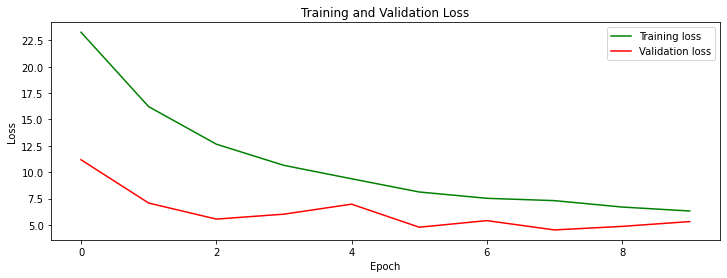

In [33]:
plt.figure(figsize=(12, 4))
plt.plot(train_losses[:], 'g', label='Training loss')
plt.plot(val_losses[:], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss");

In [49]:
import glob
  
vals = glob.glob('val/images/*.jpg')

vals.sort()
# vals

In [50]:
def get_output_from_model(model ,im, sz= 512 ):
  tfms = transforms.Compose([
        transforms.Resize((sz, sz)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

  img = tfms(im).cuda()
  img = img.unsqueeze(0)


  model.eval()

  # Get prediction
  output = model(img)
  return output

In [82]:
mm = 22
im = Image.open(vals[mm]) 

w, h = im.size
with torch.no_grad():
  output = get_output_from_model(model , im)

In [86]:
output = torch.reshape(output, ( 2 ,14)).cpu().detach().numpy()


In [92]:
j = output.copy()



w_scale = sz / w
h_scale = sz / h

# transformations

# normalize and scale bounding box

j[0] = (j[0] * w) / w_scale
j[1] = (j[1] * h) / h_scale

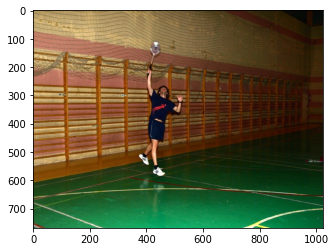

In [98]:
img = np.array(im)



image = cv2.imread(vals[mm])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



plt.imshow(image)

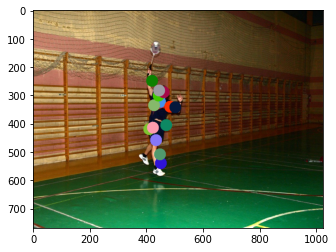

In [99]:

pointed_img = draw_point_on_image(image , j)


plt.imshow(pointed_img)







# axarr[i,0].imshow(image)
# axarr[i,1].imshow(pointed_img)
